In [70]:
import pandas as pd

# Cargar los datos
df = pd.read_csv('../../Datos/df_balanceado.csv').drop(['time'], axis=1)

# Seleccionar variables de interés
df_features = df[['count', 'winddirection_10m_dominant (°)', 'semana_del_mes', 'semana_del_anio', 'es_festivo_mexico', 'anio', 'dia_de_la_semana']]

# Definir las variables independientes (X) y dependiente (y)
X = df_features.drop('count', axis=1)
y = df_features['count']


In [128]:
[int(x) for x in np.logspace(2, 3.5, num=5)]

[100, 237, 562, 1333, 3162]

# Grid Search

In [73]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import time
import numpy as np
from itertools import product
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore') 

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [int(x) for x in np.logspace(2, 3.5, num=5)],
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [.6,.9],
    'max_features': ['sqrt', 'log2'] 
}

    
# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Inicializar listas para métricas de desempeño
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Calcular métricas de desempeño para cada fold
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        mape_list.append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
        mse_list.append(mean_squared_error(y_test, y_pred))
        rmse_list.append(mean_squared_error(y_test, y_pred, squared=False))
        #msle_list.append(mean_squared_log_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

     # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    #avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular la puntuación de validación cruzada
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    avg_score = scores.mean()
    std_score = scores.std()

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time #Segundos

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_score': avg_score,
        'std_score': std_score,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        #'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_score', ascending=False)



,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_score,std_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_r_squared,time_taken
0,100,5,5,2,0.01,0.6,sqrt,NaN,NaN,13.393970,22.897438,275.462452,16.595516,0.501965,0.906696
1,100,5,5,2,0.01,0.6,log2,NaN,NaN,13.380195,22.904288,274.088210,16.553469,0.504688,0.823554
2,100,5,5,2,0.01,0.9,sqrt,NaN,NaN,13.343740,22.776826,271.773416,16.483386,0.508769,0.916973
3,100,5,5,2,0.01,0.9,log2,NaN,NaN,13.396679,22.889595,274.392978,16.560945,0.504036,0.900520
4,100,5,5,2,0.05,0.6,sqrt,NaN,NaN,10.205868,16.667873,174.402073,13.194005,0.684810,0.789871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,3162,11,15,6,0.05,0.9,log2,NaN,NaN,10.814353,17.214350,195.643624,13.975293,0.646280,39.735723
2156,3162,11,15,6,0.10,0.6,sqrt,NaN,NaN,10.988868,17.204553,200.957847,14.170359,0.636722,32.231571
2157,3162,11,15,6,0.10,0.6,log2,NaN,NaN,11.302781,17.978203,207.143019,14.374987,0.625617,32.719056
2158,3162,11,15,6,0.10,0.9,sqrt,NaN,NaN,10.939699,17.460726,199.916035,14.128424,0.638292,39.774002


In [76]:
# Ordenar los resultados por la métrica deseada, por ejemplo, precisión (accuracy)
results_df = results_df.sort_values(by='mean_r_squared', ascending=False)

# Mostrar la mejor combinación de hiperparámetros y su rendimiento
best_params = results_df.iloc[0]  # Tomar la primera fila, que tendrá el mejor rendimiento
print("Mejor combinación de hiperparámetros:")
print(best_params)


Mejor combinación de hiperparámetros:
n_estimators                             562
max_depth                                  9
min_samples_split                         15
min_samples_leaf                           4
learning_rate                           0.01
subsample                                0.6
max_features                            sqrt
mean_score                               NaN
std_score                                NaN
mean_absolute_error                 9.763475
mean_absolute_percentage_error     15.717654
mean_squared_error                159.141591
root_mean_squared_error            12.597973
mean_r_squared                      0.712281
time_taken                          6.017212
Name: 1164, dtype: object


In [77]:
# Ordenar los resultados por la métrica deseada, por ejemplo, precisión (accuracy)
results_df = results_df.sort_values(by='mean_absolute_percentage_error', ascending=True)

# Mostrar la mejor combinación de hiperparámetros y su rendimiento
best_params = results_df.iloc[0]  # Tomar la primera fila, que tendrá el mejor rendimiento
print("Mejor combinación de hiperparámetros:")
print(best_params)


Mejor combinación de hiperparámetros:
n_estimators                             562
max_depth                                  9
min_samples_split                         15
min_samples_leaf                           6
learning_rate                           0.01
subsample                                0.9
max_features                            log2
mean_score                               NaN
std_score                                NaN
mean_absolute_error                 9.714305
mean_absolute_percentage_error     15.643429
mean_squared_error                161.475426
root_mean_squared_error            12.701023
mean_r_squared                      0.708198
time_taken                          7.149289
Name: 1179, dtype: object


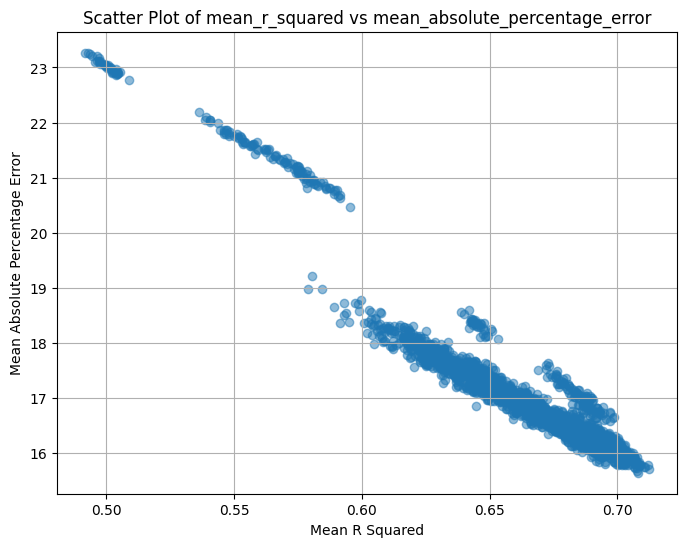

In [81]:
import matplotlib.pyplot as plt

# Assuming results_df contains your data

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['mean_r_squared'], results_df['mean_absolute_percentage_error'], alpha=0.5)
plt.title('Scatter Plot of mean_r_squared vs mean_absolute_percentage_error')
plt.xlabel('Mean R Squared')
plt.ylabel('Mean Absolute Percentage Error')
plt.grid(True)
plt.show()


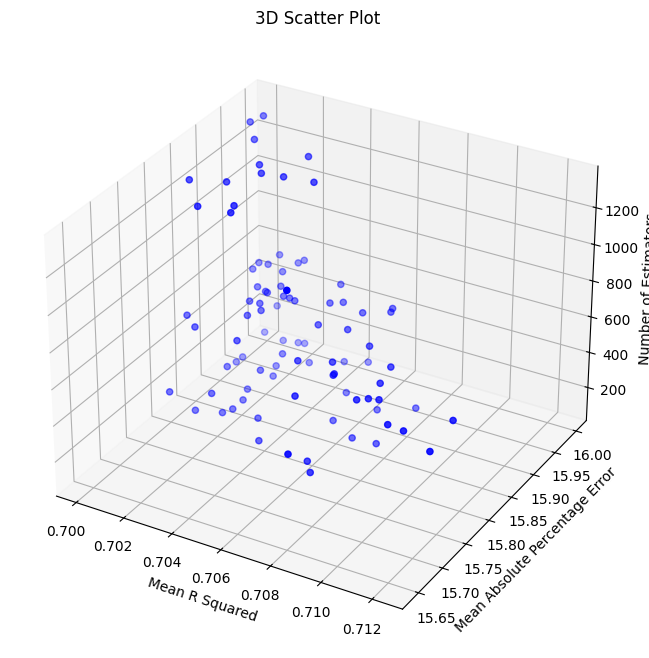

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming results_df contains your data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = best_results['mean_r_squared']
y = best_results['mean_absolute_percentage_error']
z = best_results['n_estimators']

# 3D Scatter plot
ax.scatter(x, y, z, c='blue', marker='o')

ax.set_xlabel('Mean R Squared')
ax.set_ylabel('Mean Absolute Percentage Error')
ax.set_zlabel('Number of Estimators')

plt.title('3D Scatter Plot')
plt.show()


In [107]:
best_results = results_df[(results_df['mean_absolute_percentage_error'] < 16) & (results_df['mean_r_squared'] > 0.70)].sort_values(by='mean_absolute_percentage_error', ascending=True)
columns_to_plot = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'learning_rate', 'subsample', 'max_features']

for column in columns_to_plot:
    print(f"Distinct values in column '{column}': {best_results[column].unique()}")

Distinct values in column 'n_estimators': [ 562 1333  237  100]
Distinct values in column 'max_depth': [ 9  5  7 11]
Distinct values in column 'min_samples_split': [15 10  5]
Distinct values in column 'min_samples_leaf': [6 4 2]
Distinct values in column 'learning_rate': [0.01 0.05 0.1 ]
Distinct values in column 'subsample': [0.9 0.6]
Distinct values in column 'max_features': ['log2' 'sqrt']


In [119]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import time
import numpy as np
from itertools import product
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore') 

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [237, 562],
    'max_depth': [5, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'learning_rate': [0.01],
    'subsample': [.6],
    'max_features': ['sqrt', 'log2'] 
}

    
# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Inicializar listas para métricas de desempeño
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Calcular métricas de desempeño para cada fold
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        mape_list.append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
        mse_list.append(mean_squared_error(y_test, y_pred))
        rmse_list.append(mean_squared_error(y_test, y_pred, squared=False))
        #msle_list.append(mean_squared_log_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

     # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    #avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular la puntuación de validación cruzada
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    avg_score = scores.mean()
    std_score = scores.std()

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time #Segundos

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_score': avg_score,
        'std_score': std_score,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        #'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_score', ascending=False)



,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_score,std_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_r_squared,time_taken
0,237,5,5,2,0.01,0.6,sqrt,NaN,NaN,11.001370,18.260538,196.855283,14.029303,0.644092,2.249379
1,237,5,5,2,0.01,0.6,log2,NaN,NaN,11.055134,18.399370,198.630882,14.088480,0.641087,2.257678
2,237,5,5,4,0.01,0.6,sqrt,NaN,NaN,11.029392,18.370017,196.057275,13.998621,0.645670,2.147944
3,237,5,5,4,0.01,0.6,log2,NaN,NaN,11.007680,18.362459,195.943184,13.985467,0.645688,2.126853
4,237,5,10,2,0.01,0.6,sqrt,NaN,NaN,11.051126,18.421811,197.439070,14.047151,0.642963,1.956227
5,237,5,10,2,0.01,0.6,log2,NaN,NaN,10.977560,18.312667,194.991712,13.961052,0.647595,2.036001
6,237,5,10,4,0.01,0.6,sqrt,NaN,NaN,10.999118,18.322007,195.070015,13.944239,0.647909,2.030317
7,237,5,10,4,0.01,0.6,log2,NaN,NaN,11.102090,18.463380,198.256679,14.076763,0.641795,2.026643
8,237,7,5,2,0.01,0.6,sqrt,NaN,NaN,10.433468,17.229105,178.470999,13.349496,0.677680,3.003010
9,237,7,5,2,0.01,0.6,log2,NaN,NaN,10.570888,17.517840,182.793665,13.515683,0.669778,3.064660


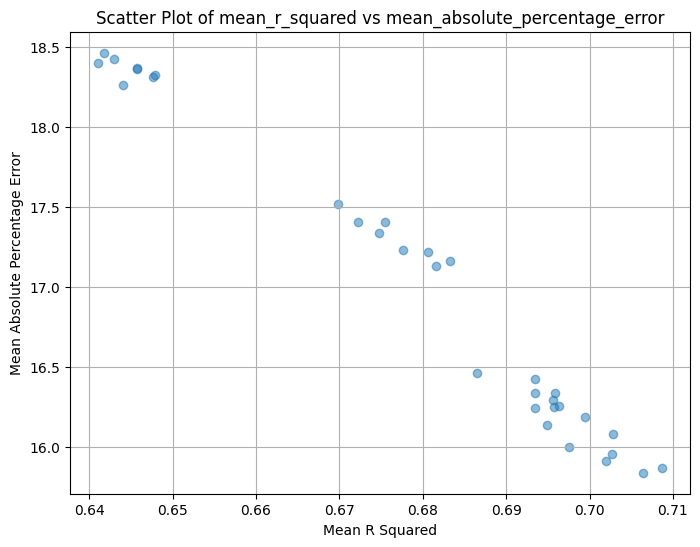

In [120]:
import matplotlib.pyplot as plt

# Assuming results_df contains your data

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['mean_r_squared'], results_df['mean_absolute_percentage_error'], alpha=0.5)
plt.title('Scatter Plot of mean_r_squared vs mean_absolute_percentage_error')
plt.xlabel('Mean R Squared')
plt.ylabel('Mean Absolute Percentage Error')
plt.grid(True)
plt.show()


In [121]:
best_results = results_df[(results_df['mean_absolute_percentage_error'] < 16) & (results_df['mean_r_squared'] > 0.70)].sort_values(by='mean_absolute_percentage_error', ascending=True)
columns_to_plot = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'learning_rate', 'subsample', 'max_features']

for column in columns_to_plot:
    print(f"Distinct values in column '{column}': {best_results[column].unique()}")

Distinct values in column 'n_estimators': [562]
Distinct values in column 'max_depth': [7]
Distinct values in column 'min_samples_split': [ 5 10]
Distinct values in column 'min_samples_leaf': [4 2]
Distinct values in column 'learning_rate': [0.01]
Distinct values in column 'subsample': [0.6]
Distinct values in column 'max_features': ['sqrt' 'log2']


In [122]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import time
import numpy as np
from itertools import product
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore') 

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [562],
    'max_depth': [7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'learning_rate': [0.01],
    'subsample': [.6],
    'max_features': ['sqrt', 'log2'] 
}

    
# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Inicializar listas para métricas de desempeño
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Calcular métricas de desempeño para cada fold
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        mape_list.append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
        mse_list.append(mean_squared_error(y_test, y_pred))
        rmse_list.append(mean_squared_error(y_test, y_pred, squared=False))
        #msle_list.append(mean_squared_log_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

     # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    #avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular la puntuación de validación cruzada
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    avg_score = scores.mean()
    std_score = scores.std()

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time #Segundos

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_score': avg_score,
        'std_score': std_score,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        #'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_score', ascending=False)



,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_score,std_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_r_squared,time_taken
0,562,7,5,2,0.01,0.6,sqrt,NaN,NaN,9.950891,16.136586,166.185554,12.873880,0.699627,6.818292
1,562,7,5,2,0.01,0.6,log2,NaN,NaN,9.752939,15.787303,162.536466,12.731725,0.706141,6.533203
2,562,7,5,4,0.01,0.6,sqrt,NaN,NaN,9.771011,15.786498,161.383736,12.684665,0.708478,6.026780
3,562,7,5,4,0.01,0.6,log2,NaN,NaN,9.819020,15.930176,164.153161,12.779133,0.703577,5.888779
4,562,7,10,2,0.01,0.6,sqrt,NaN,NaN,9.950591,16.025280,164.745151,12.830500,0.702056,6.078460
5,562,7,10,2,0.01,0.6,log2,NaN,NaN,9.859606,15.857815,164.000292,12.800520,0.703648,6.410494
6,562,7,10,4,0.01,0.6,sqrt,NaN,NaN,9.932737,16.063057,166.288795,12.870992,0.699881,5.525721
7,562,7,10,4,0.01,0.6,log2,NaN,NaN,9.864543,16.019047,165.106109,12.834980,0.701367,5.401056


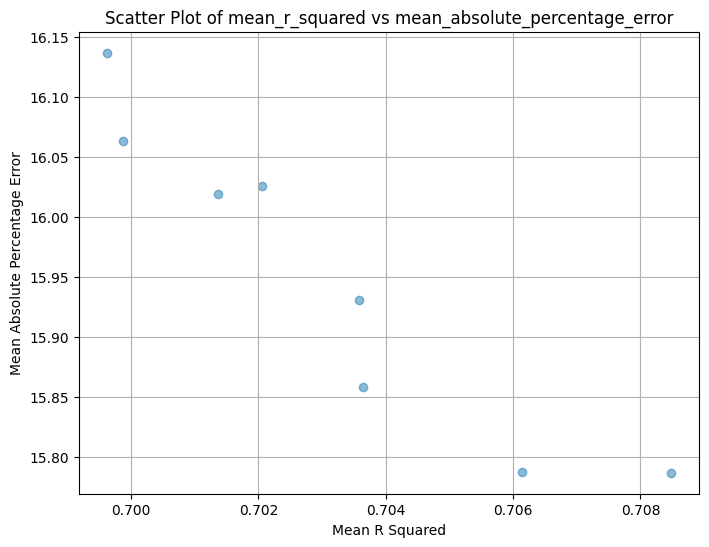

In [123]:
import matplotlib.pyplot as plt

# Assuming results_df contains your data

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['mean_r_squared'], results_df['mean_absolute_percentage_error'], alpha=0.5)
plt.title('Scatter Plot of mean_r_squared vs mean_absolute_percentage_error')
plt.xlabel('Mean R Squared')
plt.ylabel('Mean Absolute Percentage Error')
plt.grid(True)
plt.show()


In [127]:
best_results = results_df[(results_df['mean_absolute_percentage_error'] < 15.8) & (results_df['mean_r_squared'] > 0.707)].sort_values(by='mean_absolute_percentage_error', ascending=True)
columns_to_plot = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'learning_rate', 'subsample', 'max_features']

for column in columns_to_plot:
    print(f"Distinct values in column '{column}': {best_results[column].unique()}")

Distinct values in column 'n_estimators': [562]
Distinct values in column 'max_depth': [7]
Distinct values in column 'min_samples_split': [5]
Distinct values in column 'min_samples_leaf': [4]
Distinct values in column 'learning_rate': [0.01]
Distinct values in column 'subsample': [0.6]
Distinct values in column 'max_features': ['sqrt']


In [133]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import time
import numpy as np
from itertools import product
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore') 

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [562],
    'max_depth': [7],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
    'learning_rate': [0.01],
    'subsample': [.6],
    'max_features': ['sqrt'] 
}

    
# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Inicializar listas para métricas de desempeño
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Calcular métricas de desempeño para cada fold
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        mape_list.append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
        mse_list.append(mean_squared_error(y_test, y_pred))
        rmse_list.append(mean_squared_error(y_test, y_pred, squared=False))
        #msle_list.append(mean_squared_log_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

     # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    #avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular la puntuación de validación cruzada
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    avg_score = scores.mean()
    std_score = scores.std()

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time #Segundos

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_score': avg_score,
        'std_score': std_score,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        #'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_score', ascending=False)



,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_score,std_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_r_squared,time_taken
0,562,7,5,4,0.01,0.6,sqrt,NaN,NaN,9.889183,15.960409,164.955533,12.833307,0.701606,5.625688


In [135]:
import pandas as pd

# Set the display option to truncate floats to 2 decimal places
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# Sort the DataFrame by 'R-squared' column in descending order and display the top 10 rows
truncated_results = results_df[['mean_absolute_percentage_error','mean_r_squared','time_taken']]
truncated_results



,mean_absolute_percentage_error,mean_r_squared,time_taken
0,15.96,0.70,5.63


In [138]:
results_df['Modelo'] = 'Modelo optimizado'

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtra los 20 mejores resultados según el valor de R-squared
top_results = results_df.sort_values(by='mean_r_squared', ascending=False)#.head(20)

# Reorganiza el DataFrame para facilitar la visualización
df_plot = top_results.reset_index()

# Crea el violin plot
fig, ax1 = plt.subplots(figsize=(15, 8))
sns.violinplot(x='Modelo', y='mean_absolute_percentage_error', data=df_plot, inner='quartile', ax=ax1, palette='viridis')

# Ajusta el límite del eje y para MAPE
#ax1.set_ylim(20, 30)

# Añade un segundo eje y para el tiempo de ejecución
ax2 = ax1.twinx()
sns.lineplot(x='Modelo', y='time_taken', data=df_plot, ax=ax2, color='red', marker='o', label='Tiempo promedio de ejecucion (S)')

# Ajusta las leyendas y etiquetas
ax1.set_ylabel('mean_absolute_percentage_error', color='blue')
ax2.set_ylabel('Tiempo promedio de ejecucion (S)', color='red')

# Posiciona la leyenda en la parte superior
ax1.legend(loc='upper left', bbox_to_anchor=(0.5, 1.15), frameon=False)
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 1.15), frameon=False)

plt.show()


# Random Search

In [132]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import randint, uniform
import time
import numpy as np

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore') 

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
# Definir distribuciones para los hiperparámetros
param_dist = {
    'n_estimators': randint(10, 3162),  # Rango entre 10 y 200
    'max_depth': randint(5, 30),  # Rango entre 10 y 30
    'min_samples_split': randint(2, 20),  # Rango entre 2 y 10
    'min_samples_leaf': randint(1, 10),  # Rango entre 1 y 4
    'learning_rate': uniform(0.01, 0.2 - 0.01),  # Distribución uniforme entre 0.01 y 0.2
    'subsample': [0.8, 1.0],  # Lista estática
    'max_features': ['sqrt', 'log2']  # Lista estática
}

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Inicializar el GradientBoostingRegressor
model = GradientBoostingRegressor()

# Crear un RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   n_iter=100, scoring='r2', cv=cv)

# Iniciar tiempo
start_time = time.time()

# Ejecutar la búsqueda aleatoria en tus datos
random_search.fit(X, y)

# Calcular el tiempo transcurrido
time_taken = time.time() - start_time #Segundos

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Imprimir el mejor score encontrado
print("Mejor score encontrado:")
print(random_search.best_score_)

# Imprimir el tiempo tomado
print("Tiempo tomado para la búsqueda:")
print(time_taken)


Mejores hiperparámetros encontrados:
{'learning_rate': 0.01912737495251212, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 849, 'subsample': 1.0}
Mejor score encontrado:
0.700148426494898
Tiempo tomado para la búsqueda:
1025.7733821868896


# Prueba 1

In [61]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
import time
import numpy as np
from itertools import product

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2'] 
}

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Listas para almacenar resultados de métricas
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Realizar validación cruzada y calcular métricas para cada fold
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(np.mean(np.abs(y_pred - y_test)))
        mape_list.append(np.mean(np.abs((y_pred - y_test) / y_test)) * 100)
        mse_list.append(np.mean((y_pred - y_test) ** 2))
        rmse_list.append(np.sqrt(np.mean((y_pred - y_test) ** 2)))
        msle_list.append(np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2))
        r2_list.append(model.score(X_test, y_test))

    # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_squared_error', ascending=True, inplace=True)
results_df.head(50)


KeyboardInterrupt: 

[100, 163, 268, 439, 719, 1178, 1930, 3162]

In [8]:
results_df.sort_values(by='mean_r_squared', ascending=False).head(15)

,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_squared_log_error,mean_r_squared,time_taken
954,100,7,10,2,0.1,1.0,sqrt,9.932911,15.963807,164.657609,12.827808,0.040620,0.702274,1.083872
571,50,7,2,4,0.1,1.0,log2,9.896986,16.062414,165.995690,12.873916,0.041149,0.699767,0.498981
811,100,5,5,2,0.1,1.0,log2,9.928963,16.108387,166.043417,12.878075,0.041412,0.699649,0.849863
1170,150,5,10,2,0.1,1.0,sqrt,9.948581,16.017379,166.584026,12.902155,0.041763,0.698762,1.118255
773,100,5,2,2,0.1,0.8,log2,9.944193,16.061030,166.818436,12.904478,0.041526,0.698436,1.138377
628,50,7,10,2,0.1,0.8,sqrt,9.952347,16.091198,166.796160,12.906263,0.041152,0.698396,0.533404
859,100,5,10,4,0.1,1.0,log2,9.937299,16.050402,167.171127,12.918654,0.041244,0.697720,0.876173
846,100,5,10,2,0.1,1.0,sqrt,9.934525,16.082096,167.332445,12.929058,0.041744,0.697421,0.800051
594,50,7,5,2,0.1,1.0,sqrt,9.935908,16.141741,167.341895,12.926894,0.041629,0.697371,0.500200
1483,200,5,10,1,0.1,1.0,log2,9.897660,15.932662,167.427422,12.927027,0.041499,0.697188,1.428032


In [12]:
results_df.to_csv('../../Datos/results_df.csv', index=False)  # Set index=False to exclude the index column in the CSV

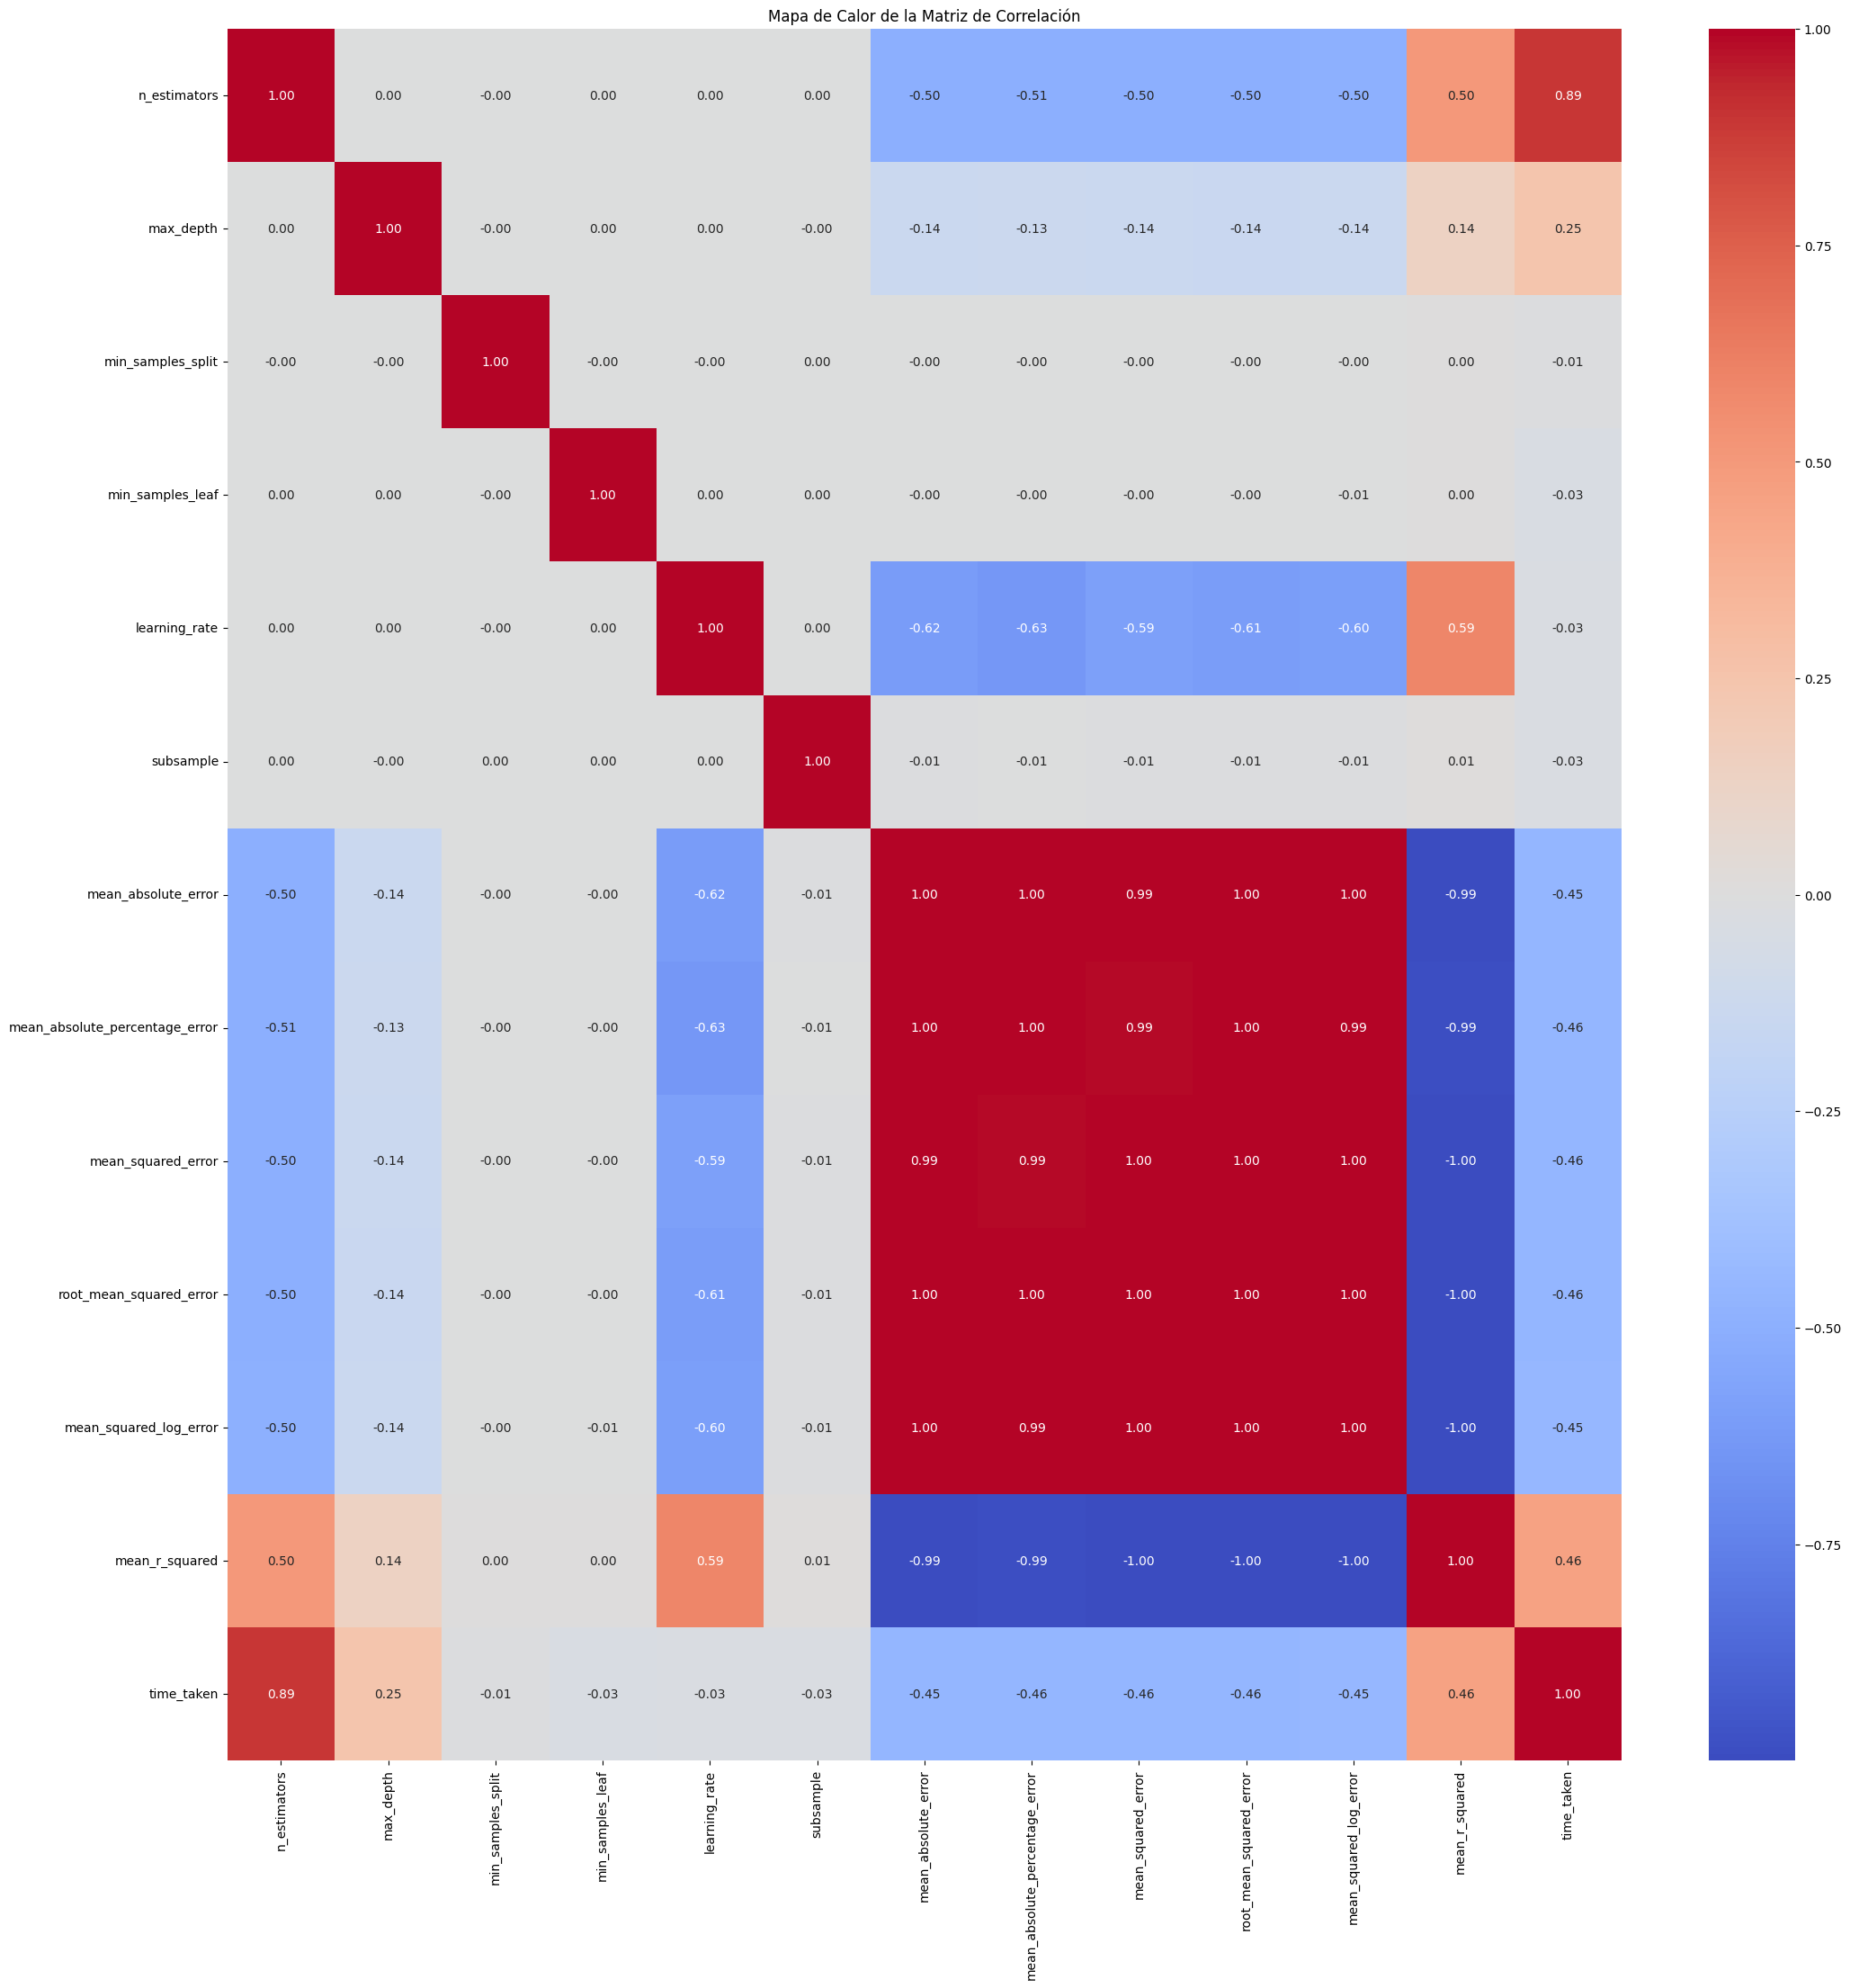

In [10]:
# Importar las bibliotecas necesarias
import pandas as pd  # Para el manejo de datos
import numpy as np   # Para operaciones numéricas
import seaborn as sns  # Para la creación de gráficos
import matplotlib.pyplot as plt  # Para visualizar gráficos

# Ignorar las advertencias para mantener un registro más limpio
import warnings
warnings.filterwarnings('ignore')

# Calcula la matriz de correlación entre las variables del DataFrame balanceado
matriz_correlacion = results_df.drop('max_features', axis=1).corr()

# Crea un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(25, 25))  # Tamaño del gráfico

# Utiliza 'sns.heatmap' para mostrar la matriz de correlación
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
# 'annot' agrega los valores en cada celda, 'cmap' elige el esquema de colores, 'fmt' define el formato de los valores

# Configura el título del gráfico
plt.title('Mapa de Calor de la Matriz de Correlación')

# Muestra el gráfico
plt.show()


In [21]:
import numpy as np

decimal_range = np.arange(0, 1.1, 0.1)

print(decimal_range)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [23]:
[int(x) for x in np.logspace(2, 3.5, num=8)]

[100, 163, 268, 439, 719, 1178, 1930, 3162]

# Prueba 2

In [2]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
import time
import numpy as np
from itertools import product

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [int(x) for x in np.logspace(2, 3.5, num=8)],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [1.0],
    'max_features': ['sqrt', 'log2'] 
}

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Listas para almacenar resultados de métricas
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Realizar validación cruzada y calcular métricas para cada fold
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(np.mean(np.abs(y_pred - y_test)))
        mape_list.append(np.mean(np.abs((y_pred - y_test) / y_test)) * 100)
        mse_list.append(np.mean((y_pred - y_test) ** 2))
        rmse_list.append(np.sqrt(np.mean((y_pred - y_test) ** 2)))
        msle_list.append(np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2))
        r2_list.append(model.score(X_test, y_test))

    # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_squared_error', ascending=True, inplace=True)
results_df.head(20)


c:\Users\fer_m\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\fer_m\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\fer_m\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\fer_m\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\fer_m\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.

,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_squared_log_error,mean_r_squared,time_taken
883,1178,5,5,1,0.01,1.0,log2,9.833076,15.946887,164.078911,12.797655,0.041032,0.703338,4.522233
882,1178,5,5,1,0.01,1.0,sqrt,9.825635,15.948676,164.237591,12.804828,0.041106,0.703025,4.615720
864,1178,5,2,1,0.01,1.0,sqrt,9.832609,15.936346,164.817376,12.827060,0.041077,0.702006,4.717357
763,719,7,2,2,0.01,1.0,log2,9.865387,15.917087,164.955222,12.835778,0.040377,0.701728,5.400040
901,1178,5,10,1,0.01,1.0,log2,9.842686,15.957903,165.015467,12.837422,0.041286,0.701620,4.933282
798,719,7,10,2,0.01,1.0,sqrt,9.882032,15.956308,165.296312,12.850265,0.040710,0.701072,5.091975
793,719,7,10,1,0.01,1.0,log2,9.845483,15.923076,165.475590,12.855248,0.040865,0.700749,5.236198
913,1178,5,10,4,0.01,1.0,log2,9.865312,15.948731,165.517312,12.854162,0.040961,0.700777,4.667030
907,1178,5,10,2,0.01,1.0,log2,9.898485,15.992382,165.540460,12.858397,0.041106,0.700673,4.775589
865,1178,5,2,1,0.01,1.0,log2,9.867997,15.994598,165.542509,12.855836,0.041281,0.700694,4.734151


In [20]:
best_results = results_df.head(3)

In [21]:
columns_to_plot = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'learning_rate', 'subsample', 'max_features']

for column in columns_to_plot:
    print(f"Distinct values in column '{column}': {best_results[column].unique()}")

Distinct values in column 'n_estimators': [1178]
Distinct values in column 'max_depth': [5]
Distinct values in column 'min_samples_split': [10  2]
Distinct values in column 'min_samples_leaf': [1]
Distinct values in column 'learning_rate': [0.01]
Distinct values in column 'subsample': [1.]
Distinct values in column 'max_features': ['sqrt' 'log2']


In [24]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
import time
import numpy as np
from itertools import product

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [1178],
    'max_depth': [5],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'learning_rate': [0.01],
    'subsample': [1.0],
    'max_features': ['log2'] 
}

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Listas para almacenar resultados de métricas
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Realizar validación cruzada y calcular métricas para cada fold
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(np.mean(np.abs(y_pred - y_test)))
        mape_list.append(np.mean(np.abs((y_pred - y_test) / y_test)) * 100)
        mse_list.append(np.mean((y_pred - y_test) ** 2))
        rmse_list.append(np.sqrt(np.mean((y_pred - y_test) ** 2)))
        msle_list.append(np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2))
        r2_list.append(model.score(X_test, y_test))

    # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_squared_error', ascending=True, inplace=True)
results_df.head(20)


c:\Users\fer_m\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_squared_log_error,mean_r_squared,time_taken
0,1178,5,10,1,0.01,1.0,log2,9.839366,15.952373,164.785274,12.826208,0.041124,0.701999,4.48227


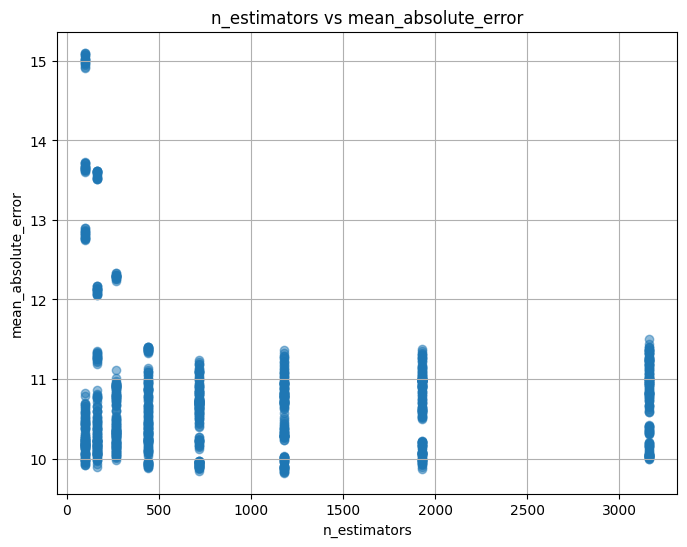

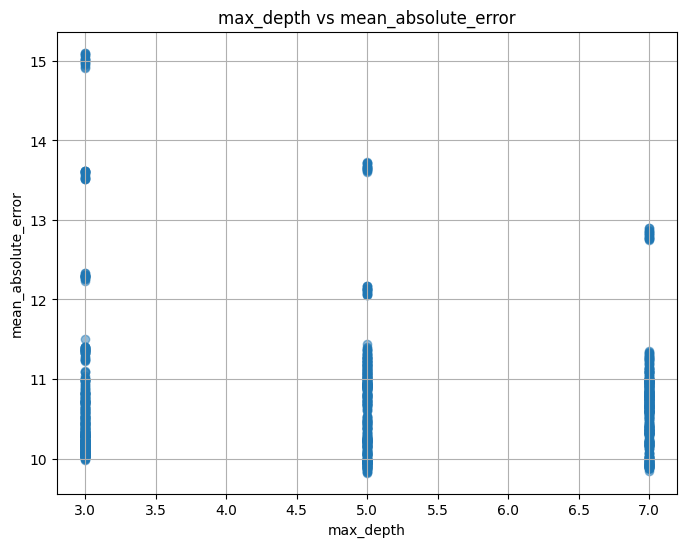

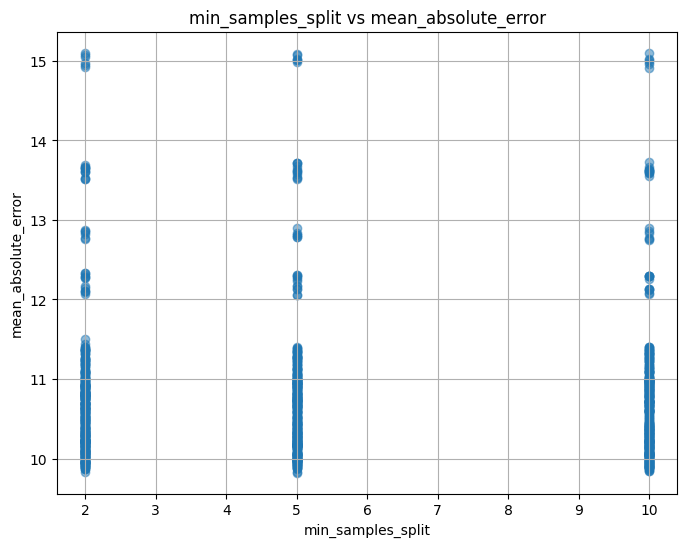

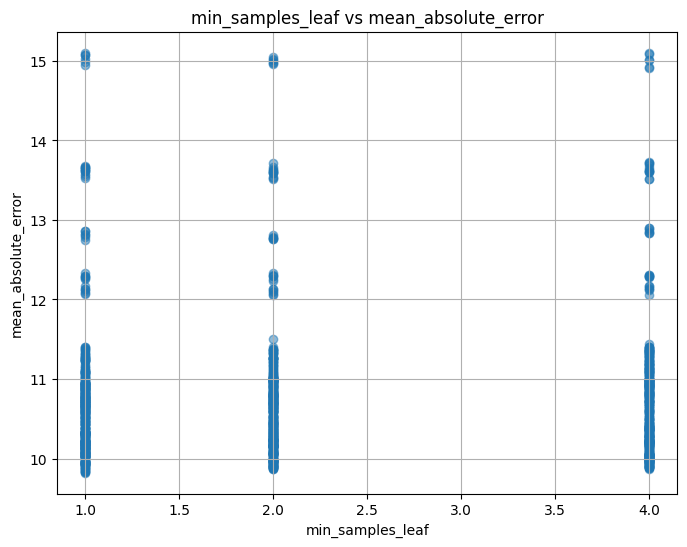

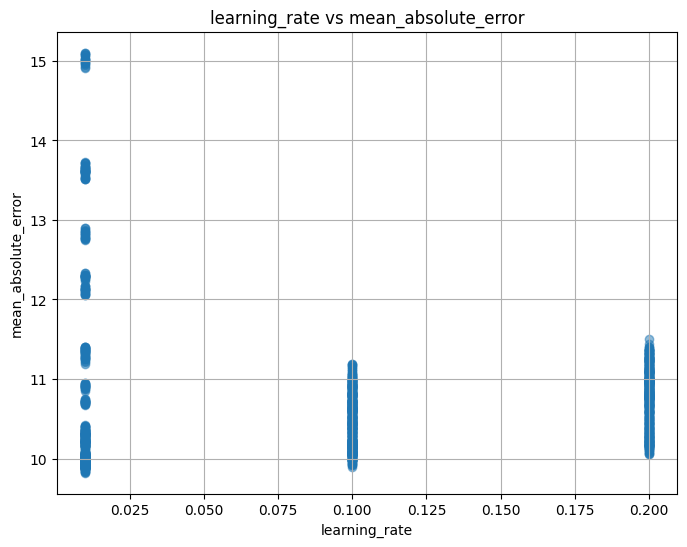

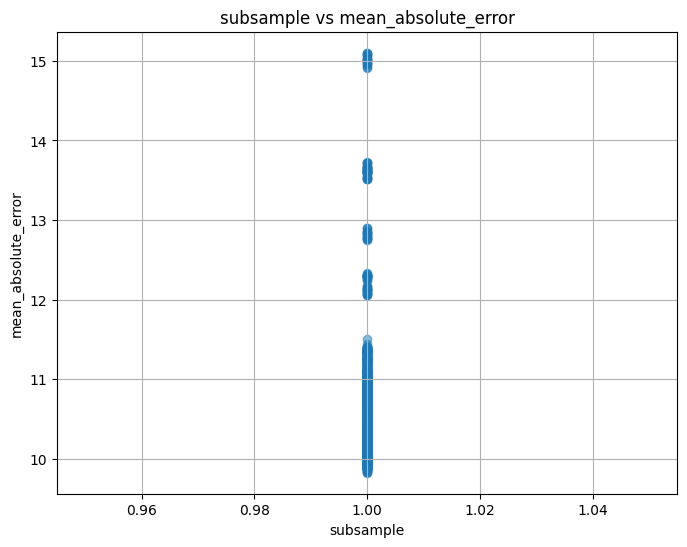

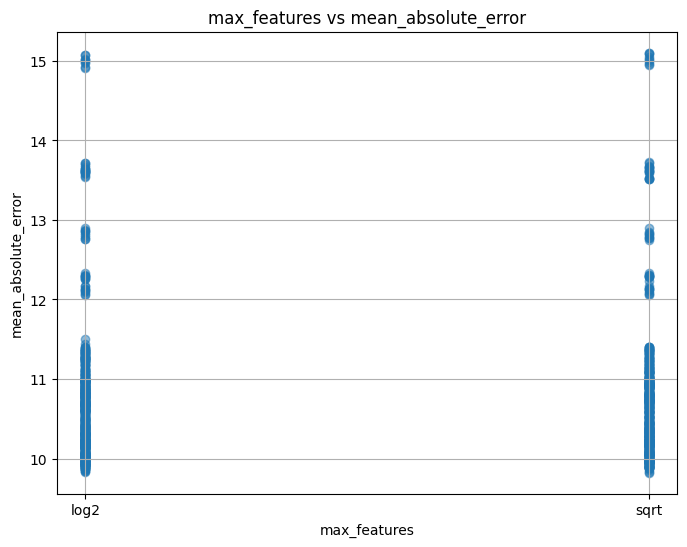

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que ya tienes tu DataFrame results_df

columns_to_plot = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'learning_rate', 'subsample', 'max_features']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))  # Establecer el tamaño del gráfico
    plt.scatter(results_df[column], results_df['mean_absolute_error'], alpha=0.5)  # Crear el gráfico de dispersión
    plt.title(f'{column} vs mean_absolute_error')  # Establecer el título del gráfico
    plt.xlabel(column)  # Etiqueta del eje x
    plt.ylabel('mean_absolute_error')  # Etiqueta del eje y
    plt.grid(True)  # Mostrar cuadrícula
    plt.show()  # Mostrar el gráfico


# Prueba 3

In [52]:
[range(7,10,1)]

[range(7, 10)]

In [55]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
import time
import numpy as np
from itertools import product

# Definir tus datos y etiquetas
X, y = df_features.drop(['count'], axis=1), df_features['count']

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [3162],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [1.0],
    'max_features': ['sqrt', 'log2'] 
}

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear lista para almacenar resultados
results_list = []

# Realizar la búsqueda de hiperparámetros de forma manual
for params in product(*param_grid.values()):
    # Desempaquetar los parámetros
    n_estimators, max_depth, min_samples_split, min_samples_leaf, learning_rate, subsample, max_features = params

    # Iniciar tiempo
    start_time = time.time()

    # Definir el modelo con los hiperparámetros actuales
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        max_features=max_features
    )

    # Listas para almacenar resultados de métricas
    mae_list, mape_list, mse_list, rmse_list, msle_list, r2_list = [], [], [], [], [], []

    # Realizar validación cruzada y calcular métricas para cada fold
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(np.mean(np.abs(y_pred - y_test)))
        mape_list.append(np.mean(np.abs((y_pred - y_test) / y_test)) * 100)
        mse_list.append(np.mean((y_pred - y_test) ** 2))
        rmse_list.append(np.sqrt(np.mean((y_pred - y_test) ** 2)))
        msle_list.append(np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2))
        r2_list.append(model.score(X_test, y_test))

    # Calcular promedio de métricas de desempeño
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_msle = np.mean(msle_list)
    avg_r2 = np.mean(r2_list)

    # Calcular el tiempo transcurrido
    time_taken = time.time() - start_time

    # Agregar resultados a la lista
    results_list.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'max_features': max_features,
        'mean_absolute_error': avg_mae,
        'mean_absolute_percentage_error': avg_mape,
        'mean_squared_error': avg_mse,
        'root_mean_squared_error': avg_rmse,
        'mean_squared_log_error': avg_msle,
        'mean_r_squared': avg_r2,
        'time_taken': time_taken,
    })

# Convertir la lista de resultados a DataFrame
results_df = pd.DataFrame(results_list)

# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_r_squared', ascending=False, inplace=True)
results_df.head(20)


,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_squared_log_error,mean_r_squared,time_taken
73,3162,5,5,1,0.01,1.0,log2,10.078680,16.249363,169.205938,12.996906,0.042707,0.694032,11.333762
90,3162,5,10,1,0.01,1.0,sqrt,10.060255,16.207982,169.218142,12.998988,0.042815,0.694045,11.005275
12,3162,3,2,4,0.01,1.0,sqrt,9.998656,16.134567,169.605332,13.012086,0.042845,0.693371,10.317499
18,3162,3,5,1,0.01,1.0,sqrt,9.993455,16.179242,169.714404,13.015912,0.044137,0.693073,8.449146
37,3162,3,10,1,0.01,1.0,log2,10.008410,16.178595,169.861136,13.021557,0.043772,0.692821,7.839642
49,3162,3,10,4,0.01,1.0,log2,9.993347,16.164785,169.958040,13.025795,0.043020,0.692727,7.864997
42,3162,3,10,2,0.01,1.0,sqrt,10.017610,16.173514,170.038361,13.030492,0.043457,0.692482,7.711273
31,3162,3,5,4,0.01,1.0,log2,10.001161,16.173484,170.211483,13.035035,0.042947,0.692265,7.701949
0,3162,3,2,1,0.01,1.0,sqrt,10.005945,16.173365,170.430997,13.045818,0.044376,0.691808,7.595615
30,3162,3,5,4,0.01,1.0,sqrt,10.026945,16.209256,170.549849,13.048438,0.043092,0.691646,7.696742


In [57]:
# Imprimir el DataFrame con los resultados
results_df.sort_values(by='mean_r_squared', ascending=False).head(20)


,n_estimators,max_depth,min_samples_split,min_samples_leaf,learning_rate,subsample,max_features,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,mean_squared_log_error,mean_r_squared,time_taken
90,3162,5,10,1,0.01,1.0,sqrt,10.060255,16.207982,169.218142,12.998988,0.042815,0.694045,11.005275
73,3162,5,5,1,0.01,1.0,log2,10.078680,16.249363,169.205938,12.996906,0.042707,0.694032,11.333762
12,3162,3,2,4,0.01,1.0,sqrt,9.998656,16.134567,169.605332,13.012086,0.042845,0.693371,10.317499
18,3162,3,5,1,0.01,1.0,sqrt,9.993455,16.179242,169.714404,13.015912,0.044137,0.693073,8.449146
37,3162,3,10,1,0.01,1.0,log2,10.008410,16.178595,169.861136,13.021557,0.043772,0.692821,7.839642
49,3162,3,10,4,0.01,1.0,log2,9.993347,16.164785,169.958040,13.025795,0.043020,0.692727,7.864997
42,3162,3,10,2,0.01,1.0,sqrt,10.017610,16.173514,170.038361,13.030492,0.043457,0.692482,7.711273
31,3162,3,5,4,0.01,1.0,log2,10.001161,16.173484,170.211483,13.035035,0.042947,0.692265,7.701949
0,3162,3,2,1,0.01,1.0,sqrt,10.005945,16.173365,170.430997,13.045818,0.044376,0.691808,7.595615
30,3162,3,5,4,0.01,1.0,sqrt,10.026945,16.209256,170.549849,13.048438,0.043092,0.691646,7.696742
